In [27]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [28]:
# Define the standard Kolmogorov–Arnold Neural Network (KAN)
def standard_kan(input_dim, output_dim, num_basis):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))
    model.add(layers.Dense(num_basis, activation='linear'))  # Fixed basis functions
    model.add(layers.Dense(output_dim))
    return model


In [29]:
class AdaptiveKAN(layers.Layer):
    def __init__(self, num_basis, input_dim):
        super(AdaptiveKAN, self).__init__()
        self.num_basis = num_basis
        self.input_dim = input_dim
        # Rename weights to basis_weights to avoid conflict
        self.centers = self.add_weight(name='centers', shape=(num_basis, input_dim), initializer='random_normal')
        self.basis_weights = self.add_weight(name='basis_weights', shape=(num_basis, 1), initializer='random_normal')

    def call(self, inputs):
        # Compute distances between inputs and the basis centers
        distances = tf.norm(inputs[:, None] - self.centers, axis=-1)
        # Radial Basis Function (Gaussian kernel)
        basis_functions = tf.exp(-distances ** 2)
        return tf.matmul(basis_functions, self.basis_weights)



# Define the full Adaptive KAN model
def adaptive_kan(input_dim, output_dim, num_basis):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))
    model.add(AdaptiveKAN(num_basis, input_dim))
    model.add(layers.Dense(output_dim))
    return model


In [30]:
# Create synthetic data with noise
np.random.seed(42)

# Generate inputs
X = np.linspace(0, 10, 1000).reshape(-1, 1)
# Generate target outputs with noise added to sine wave
noise = np.random.normal(0, 0.1, X.shape)  # Normal noise
y = np.sin(X) + noise  # Target function with noise

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
# Model parameters
input_dim = 1
output_dim = 1
num_basis = 10  # Number of basis functions

# Control experiment: Standard KAN
control_model = standard_kan(input_dim, output_dim, num_basis)
control_model.compile(optimizer='adam', loss='mse')

# Experimental setup: Adaptive KAN
adaptive_model = adaptive_kan(input_dim, output_dim, num_basis)
adaptive_model.compile(optimizer='adam', loss='mse')


In [32]:
# Train the models
control_history = control_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
adaptive_history = adaptive_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.1055 - val_loss: 7.9780
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4055 - val_loss: 2.8323
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1560 - val_loss: 0.9749
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8674 - val_loss: 0.4904
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5416 - val_loss: 0.4066
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4882 - val_loss: 0.3992
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4592 - val_loss: 0.3989
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4585 - val_loss: 0.3990
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4877 - val_loss: 0.3987
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4751 - val_loss: 0.3986
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4938 - val_loss: 0.3984
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


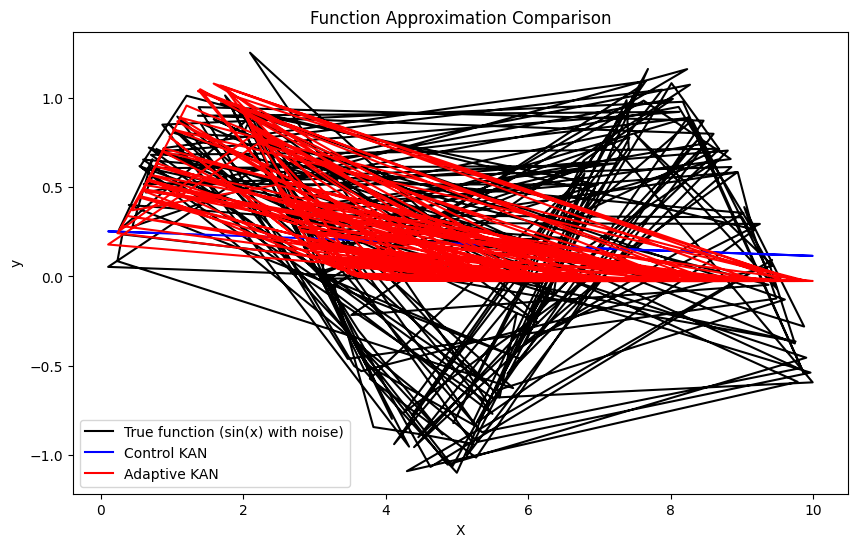

In [33]:
# Get predictions from both models
control_preds = control_model.predict(X_test)
adaptive_preds = adaptive_model.predict(X_test)

# Plotting the results
plt.figure(figsize=(10, 6))

# True function
plt.plot(X_test, y_test, label='True function (sin(x) with noise)', color='black')

# Control model prediction
plt.plot(X_test, control_preds, label='Control KAN', color='blue')

# Adaptive model prediction
plt.plot(X_test, adaptive_preds, label='Adaptive KAN', color='red')

# Adding legend and labels
plt.legend()
plt.title('Function Approximation Comparison')
plt.xlabel('X')
plt.ylabel('y')
plt.show()


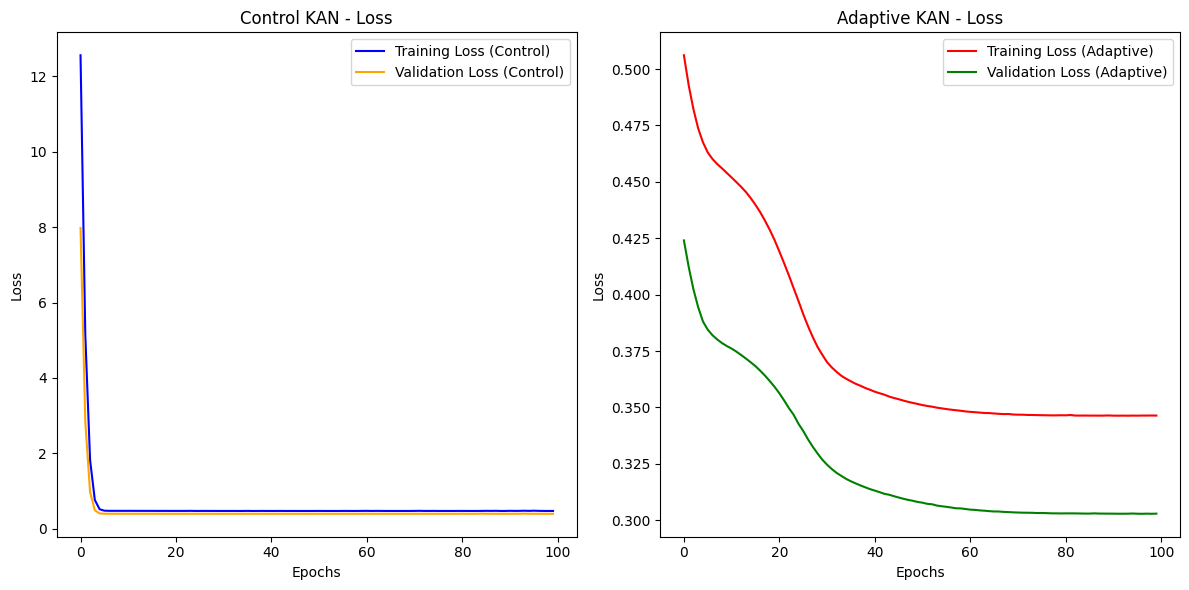

In [34]:
# Plot the training and validation loss curves for both models
plt.figure(figsize=(12, 6))

# Control model loss
plt.subplot(1, 2, 1)
plt.plot(control_history.history['loss'], label='Training Loss (Control)', color='blue')
plt.plot(control_history.history['val_loss'], label='Validation Loss (Control)', color='orange')
plt.title('Control KAN - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adaptive model loss
plt.subplot(1, 2, 2)
plt.plot(adaptive_history.history['loss'], label='Training Loss (Adaptive)', color='red')
plt.plot(adaptive_history.history['val_loss'], label='Validation Loss (Adaptive)', color='green')
plt.title('Adaptive KAN - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
# Compare the final loss values
control_train_loss = control_history.history['loss'][-1]
control_val_loss = control_history.history['val_loss'][-1]
adaptive_train_loss = adaptive_history.history['loss'][-1]
adaptive_val_loss = adaptive_history.history['val_loss'][-1]

print(f"Control KAN - Final Training Loss: {control_train_loss}")
print(f"Control KAN - Final Validation Loss: {control_val_loss}")
print(f"Adaptive KAN - Final Training Loss: {adaptive_train_loss}")
print(f"Adaptive KAN - Final Validation Loss: {adaptive_val_loss}")


Control KAN - Final Training Loss: 0.47268667817115784
Control KAN - Final Validation Loss: 0.39721083641052246
Adaptive KAN - Final Training Loss: 0.3463902175426483
Adaptive KAN - Final Validation Loss: 0.3029293715953827


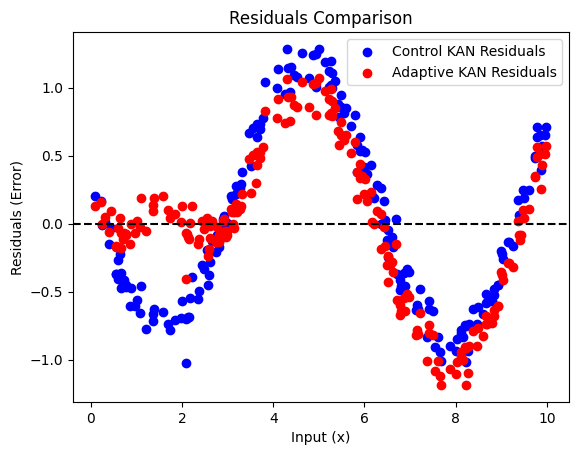

In [38]:
plt.scatter(X_test, control_preds - y_test, label="Control KAN Residuals", color='blue')
plt.scatter(X_test, adaptive_preds - y_test, label="Adaptive KAN Residuals", color='red')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Input (x)")
plt.ylabel("Residuals (Error)")
plt.legend()
plt.title("Residuals Comparison")
plt.show()
